In [1]:
#setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
from datetime import timedelta
import timeit

In [2]:
#Read in data
df = pd.read_csv('../1 data preparation/20190401-20200312_items_prepped.csv')

# First benchmarks

From the titanic challenge we have learnt it is a good idea to start with some simple analysis that can be used as a benchmark for more complex analysis. For this we will simply check:
- what's the profit/loss if we would always have betted (pre-game) on home favourites
- what's the profit/loss if we would always have betted (pre-game) on away favourites
- what's the profit/loss if we would always have betted (pre-game) on home underdogs
- what's the profit/loss if we would always have betted (pre-game) on away underdogs

We have 840 games with an observation just before the start of the game (mins15 == 0). Out of those 64% (541) were home favourite games:

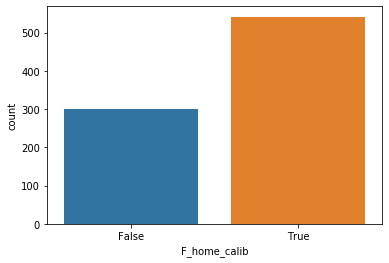

In [3]:
sns.countplot(df[df['mins15'] == 0]['F_home_calib'])

In [4]:
df[df['mins15'] == 0]['F_home_calib'].value_counts()/df[df['mins15'] == 0].shape[0]

True     0.644048
False    0.355952
Name: F_home_calib, dtype: float64

### Home favourites

In our dataset the quotes for the home favourites are centered around 2:

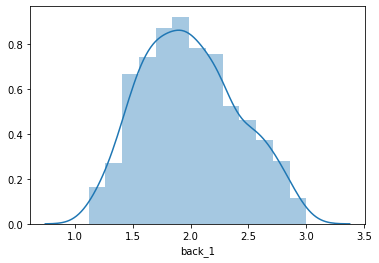

In [5]:
sns.distplot(df[(df['mins15'] == 0) & (df['F_home_calib'])]['back_1'])

Out of 541 games, home favourites win 274 times, 152 draws, 115 losses:

In [6]:
#win
df_sub = df[(df['mins15'] == 0) & (df['F_home_calib'])].copy()
df_sub.loc[:,'win'] = 0

In [7]:
df_sub.loc[((df_sub['endscore_label'].str[:2] == 'F+') & (df_sub['endscore_label'] != 'F+0')),'win'] = 1

In [8]:
df_sub['win'].value_counts()

1    274
0    267
Name: win, dtype: int64

In [12]:
df_sub['endscore_label'].value_counts()

F+0    152
F+1    131
F+2     83
F-1     72
F+3     52
F-2     30
F-3     13
F+4      8
Name: endscore_label, dtype: int64

In [13]:
#factor odds
df_sub.loc[:,'odds_factor'] = pd.cut(df_sub['back_1'],5)

In [14]:
#factor_midpoints
yields = df_sub.groupby('odds_factor')['back_1'].mean().reset_index().sort_values(by=['odds_factor'])
yields.columns = ['odds_factor', 'midpoint']
yields

,odds_factor,midpoint
0,"(1.118, 1.496]",1.363438
1,"(1.496, 1.872]",1.694788
2,"(1.872, 2.248]",2.053758
3,"(2.248, 2.624]",2.423137
4,"(2.624, 3.0]",2.773333


In [15]:
df_sub['odds_factor'].value_counts()

(1.872, 2.248]    165
(1.496, 1.872]    165
(2.248, 2.624]    102
(1.118, 1.496]     64
(2.624, 3.0]       45
Name: odds_factor, dtype: int64

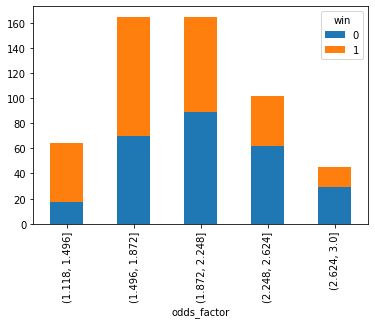

In [16]:
pd.crosstab(df_sub['odds_factor'],df_sub['win']).plot(kind='bar',stacked=True)

No surprise: big favourites win more than slight favourites.

#### Outcomes

In [17]:
#profit
df_sub.loc[:,'profit'] = df_sub['win'] * df_sub['back_1'] - 1

In [18]:
#profit per category
profits = df_sub.groupby('odds_factor')['profit'].sum().reset_index().sort_values(by=['odds_factor'])
yields = pd.merge(yields,profits,on='odds_factor')
yields

,odds_factor,midpoint,profit
0,"(1.118, 1.496]",1.363438,-0.71
1,"(1.496, 1.872]",1.694788,-5.15
2,"(1.872, 2.248]",2.053758,-9.65
3,"(2.248, 2.624]",2.423137,-5.62
4,"(2.624, 3.0]",2.773333,-0.74


In [19]:
#counts per category
counts = df_sub.groupby('odds_factor')['profit'].count().reset_index().sort_values(by=['odds_factor'])
counts.columns = ['odds_factor','counts']
yields = pd.merge(yields,counts,on='odds_factor')
yields

,odds_factor,midpoint,profit,counts
0,"(1.118, 1.496]",1.363438,-0.71,64
1,"(1.496, 1.872]",1.694788,-5.15,165
2,"(1.872, 2.248]",2.053758,-9.65,165
3,"(2.248, 2.624]",2.423137,-5.62,102
4,"(2.624, 3.0]",2.773333,-0.74,45


In [20]:
#wins per category
wins = df_sub.groupby('odds_factor')['win'].sum().reset_index().sort_values(by=['odds_factor'])
wins.columns = ['odds_factor','wins']
yields = pd.merge(yields,wins,on='odds_factor')
yields['win_perc'] = yields['wins'] / yields['counts']

In [21]:
#yields per category (percentage profit)
yields.loc[:,'yield'] = yields['profit'] / yields['counts']
yields

,odds_factor,midpoint,profit,counts,wins,win_perc,yield
0,"(1.118, 1.496]",1.363438,-0.71,64,47,0.734375,-0.011094
1,"(1.496, 1.872]",1.694788,-5.15,165,95,0.575758,-0.031212
2,"(1.872, 2.248]",2.053758,-9.65,165,76,0.460606,-0.058485
3,"(2.248, 2.624]",2.423137,-5.62,102,40,0.392157,-0.055098
4,"(2.624, 3.0]",2.773333,-0.74,45,16,0.355556,-0.016444


In all categories, betting on the home favourite leads to a loss in our data sample. Now the question is, is this significant?

Bets are binary, you either win or lose. The binomial distribution can be used to inform us about the possible distribution of wins and losses for a sample of bets that are subject to randomness. For a sample of n bets with a 'true' win probability of p, the **standard deviation** of **respectively win percentages** and **yields (profit over turnover)**, is given by ([source](https://www.sportstradingnetwork.com/article/how-to-model-your-range-of-possible-betting-returns/)):

<img src="../0 images/binomial_stdev.png">

For p we will use the probability implied in the odds: p = 1/odds.

We will calculate this for every bucket's midpoint.

In [22]:
yields['p_win'] = 1 / yields['midpoint']
yields['stdev'] = np.sqrt(yields['midpoint']-1)/np.sqrt(yields['counts'])
yields['nr_stdevs'] = yields['yield'] / yields['stdev']
yields

,odds_factor,midpoint,profit,counts,wins,win_perc,yield,p_win,stdev,nr_stdevs
0,"(1.118, 1.496]",1.363438,-0.71,64,47,0.734375,-0.011094,0.733440,0.075357,-0.147215
1,"(1.496, 1.872]",1.694788,-5.15,165,95,0.575758,-0.031212,0.590044,0.064891,-0.480993
2,"(1.872, 2.248]",2.053758,-9.65,165,76,0.460606,-0.058485,0.486912,0.079915,-0.731838
3,"(2.248, 2.624]",2.423137,-5.62,102,40,0.392157,-0.055098,0.412688,0.118120,-0.466458
4,"(2.624, 3.0]",2.773333,-0.74,45,16,0.355556,-0.016444,0.360577,0.198513,-0.082838


So all these negative yields are within 1 standard deviation, it could be by chance...

In what follows we will repeat the analysis for away favourites, home underdogs, away underdogs, and betting the draw. For this we build a routine.

## Routine

In [23]:
def profit_table(df, mins15 = 0, homefav = True, bet = "back_1", buckets = 5, qcut = False):
    '''
    This function takes in the whole prepped dataframe and some strategy parameters.
    bet should be "back_1", "back_X" or "back_2"
    It returns a table for profit analysis.
    '''
    #subset
    if (homefav):
        df_sub = df[(df['mins15'] == mins15) & (df['F_home_calib'])].copy()
    else:
        df_sub = df[(df['mins15'] == mins15) & (~df['F_home_calib'])].copy()
    
    #bet_on_fav
    if ((homefav & (bet == "back_1")) | (~homefav & (bet == "back_2"))):
        bet_on_fav = True
    else:
        bet_on_fav = False
    
    #win
    df_sub.loc[:,'win'] = 0
    if (bet_on_fav):
        df_sub.loc[((df_sub['endscore_label'].str[:2] == 'F+') & ~(df_sub['endscore_label']=='F+0')),'win'] = 1
    elif (bet == "back_X"):
        df_sub.loc[(df_sub['endscore_label']=='F+0'),'win'] = 1
    else:
        df_sub.loc[(df_sub['endscore_label'].str[:2] == 'F-'),'win'] = 1
    
    #factor odds
    if qcut:
        df_sub.loc[:,'odds_factor'] = pd.qcut(df_sub[bet],buckets)
    else:
        df_sub.loc[:,'odds_factor'] = pd.cut(df_sub[bet],buckets)
    
    #profit
    df_sub.loc[:,'profit'] = df_sub['win'] * df_sub[bet] - 1
    
    #midpoint per category
    yields = df_sub.groupby('odds_factor')[bet].mean().reset_index().sort_values(by=['odds_factor'])
    yields.columns = ['odds_factor', 'midpoint']
    
    #profit per category
    profits = df_sub.groupby('odds_factor')['profit'].sum().reset_index().sort_values(by=['odds_factor'])
    yields = pd.merge(yields,profits,on='odds_factor')
    
    #counts per category
    counts = df_sub.groupby('odds_factor')['profit'].count().reset_index().sort_values(by=['odds_factor'])
    counts.columns = ['odds_factor','counts']
    yields = pd.merge(yields,counts,on='odds_factor')
    
    #wins per category
    wins = df_sub.groupby('odds_factor')['win'].sum().reset_index().sort_values(by=['odds_factor'])
    wins.columns = ['odds_factor','wins']
    yields = pd.merge(yields,wins,on='odds_factor')
    yields['win_perc'] = yields['wins'] / yields['counts']
    
    #yields per category (percentage profit)
    yields.loc[:,'yield'] = yields['profit'] / yields['counts']
    
    #nr_stdevs per category
    yields['p_win'] = 1 / yields['midpoint']
    yields['stdev'] = np.sqrt(yields['midpoint']-1)/np.sqrt(yields['counts'])
    yields['nr_stdevs'] = yields['yield'] / yields['stdev']
    
    return yields

### home favourites

In [24]:
profit_table(df, mins15 = 0, homefav = True, bet = "back_1", buckets = 5, qcut = True)

,odds_factor,midpoint,profit,counts,wins,win_perc,yield,p_win,stdev,nr_stdevs
0,"(1.1190000000000002, 1.61]",1.444128,-0.60,109,76,0.697248,-0.005505,0.692459,0.063832,-0.086235
1,"(1.61, 1.85]",1.737143,-2.86,112,63,0.562500,-0.025536,0.575658,0.081127,-0.314761
2,"(1.85, 2.08]",1.975752,-4.21,113,55,0.486726,-0.037257,0.506136,0.092925,-0.400934
3,"(2.08, 2.36]",2.225149,-9.94,101,41,0.405941,-0.098416,0.449408,0.110137,-0.893576
4,"(2.36, 3.0]",2.620377,-4.26,106,39,0.367925,-0.040189,0.381624,0.123639,-0.325049


Betting on the home favourite leads to negative yields in every category. All within 1 standard deviation so it could be by chance.

### away favourites

In [33]:
profit_table(df, mins15 = 0, homefav = False, bet = "back_2", buckets = 15, qcut = True)

,odds_factor,midpoint,profit,counts,wins,win_perc,yield,p_win,stdev,nr_stdevs
0,"(1.169, 1.47]",1.359524,3.34,21,18,0.857143,0.159048,0.735552,0.130844,1.215550
1,"(1.47, 1.57]",1.527619,-1.20,21,13,0.619048,-0.057143,0.654613,0.158508,-0.360505
2,"(1.57, 1.66]",1.626316,-2.73,19,10,0.526316,-0.143684,0.614887,0.181560,-0.791387
3,"(1.66, 1.72]",1.695500,2.02,20,13,0.650000,0.101000,0.589797,0.186481,0.541611
4,"(1.72, 1.78]",1.756500,-0.66,20,11,0.550000,-0.033000,0.569314,0.194487,-0.169678
5,"(1.78, 1.9]",1.847727,-3.42,22,10,0.454545,-0.155455,0.541205,0.196298,-0.791930
6,"(1.9, 1.96]",1.940000,5.35,18,12,0.666667,0.297222,0.515464,0.228522,1.300630
7,"(1.96, 2.019]",1.987222,-0.13,18,9,0.500000,-0.007222,0.503215,0.234192,-0.030839
8,"(2.019, 2.1]",2.059048,-2.58,21,9,0.428571,-0.122857,0.485661,0.224568,-0.547082
9,"(2.1, 2.213]",2.148421,-6.24,19,6,0.315789,-0.328421,0.465458,0.245852,-1.335849


Betting on the away favourite leads to positive yields in the first category (big favourite). Around 1 standard deviation. However not too many observations...

### home underdogs

In [37]:
profit_table(df, mins15 = 0, homefav = False, bet = "back_1", buckets = 4, qcut = True)

,odds_factor,midpoint,profit,counts,wins,win_perc,yield,p_win,stdev,nr_stdevs
0,"(2.7390000000000003, 3.35]",3.074286,-21.94,77,18,0.233766,-0.284935,0.325279,0.164130,-1.736029
1,"(3.35, 4.2]",3.803704,-5.40,81,20,0.246914,-0.066667,0.262902,0.186047,-0.358332
2,"(4.2, 5.5]",4.871429,37.40,70,22,0.314286,0.534286,0.205279,0.235173,2.271888
3,"(5.5, 19.0]",7.764789,-5.40,71,10,0.140845,-0.076056,0.128787,0.308673,-0.246398


Medium home underdogs (>4.20 and <= 5.50) seem to be a good bet.

### away underdogs

In [56]:
profit_table(df, mins15 = 0, homefav = True, bet = "back_2", buckets = 3, qcut = True)

,odds_factor,midpoint,profit,counts,wins,win_perc,yield,p_win,stdev,nr_stdevs
0,"(2.6790000000000003, 3.9]",3.304396,-23.77,182,49,0.269231,-0.130604,0.302627,0.112523,-1.160687
1,"(3.9, 5.4]",4.559615,-21.15,182,36,0.197802,-0.116209,0.219317,0.139851,-0.830947
2,"(5.4, 34.0]",8.300000,39.20,177,30,0.169492,0.221469,0.120482,0.203084,1.090531


Also here, big away underdogs (between 5.40 and 10) seem to be a good bet, however just 1 standard deviation.

### draws with home favourite

In [62]:
profit_table(df, mins15 = 0, homefav = True, bet = "back_X", buckets = 5, qcut = True)

,odds_factor,midpoint,profit,counts,wins,win_perc,yield,p_win,stdev,nr_stdevs
0,"(2.779, 3.4]",3.204921,-3.36,126,38,0.301587,-0.026667,0.312020,0.132285,-0.201585
1,"(3.4, 3.6]",3.530392,50.05,102,43,0.421569,0.490686,0.283255,0.157505,3.115373
2,"(3.6, 3.9]",3.770833,15.80,120,36,0.300000,0.131667,0.265193,0.151955,0.866485
3,"(3.9, 4.3]",4.086628,-8.30,86,19,0.220930,-0.096512,0.244701,0.189449,-0.509433
4,"(4.3, 12.0]",5.542991,-24.60,107,16,0.149533,-0.229907,0.180408,0.206053,-1.115764


Betting the draw seems to be quite a good idea when the home team is medium favourite. Draw quote between 3.40 and 3.90

### draws with away favourite

In [65]:
profit_table(df, mins15 = 0, homefav = False, bet = "back_X", buckets = 3, qcut = True)

,odds_factor,midpoint,profit,counts,wins,win_perc,yield,p_win,stdev,nr_stdevs
0,"(2.799, 3.6]",3.381635,31.30,104,40,0.384615,0.300962,0.295715,0.151329,1.988795
1,"(3.6, 4.0]",3.826768,-3.45,99,25,0.252525,-0.034848,0.261317,0.168977,-0.206232
2,"(4.0, 10.0]",4.821875,-40.10,96,12,0.125000,-0.417708,0.207388,0.199527,-2.093488


Betting the draw also seems to be quite a good idea when the away team is slight favourite (draw quote <=3.60)

# Conclusion

For our sample dataset the winning strategies were:
- betting on the big away favourites
- betting on the medium home underdogs
- betting on the big away underdogs
- betting on the draw when the home team is medium favourite
- betting on the draw when the away team is slight favourite

<img src="../0 images/strategy.png">

Of course we are fully aware that this is not sound analysis. When investigating all the options in a sample set we will always find a "winning" strategy, just like in this [xkcd cartoon](https://xkcd.com/882/). We at least need an out-of-sample test.

### Some aftermath... Is there a general bias towards draw?

Betting the draw for slight away and medium home favourites seems to be the strategy backed by the most evidence (highest stdevs). Probably this is because our sample set has a general bias towards the draw. Let's investigate this.

In [66]:
def alldraws_profit_table(df, buckets = 1, qcut = True):
    #subset, always bet the draw
    df_sub = df[(df['mins15'] == 0)].copy()
    df_sub.loc[:,'win'] = 0
    df_sub.loc[(df_sub['endscore_label']=='F+0'),'win'] = 1
    df_sub['p_X'] = 1/df_sub['back_X'] #the probability for the draw implied by the bookmaker odds
    
    #split
    if qcut:
        df_sub['p_X_factor'] = pd.qcut(df_sub['p_X'],buckets)
    else:
        df_sub['p_X_factor'] = pd.cut(df_sub['p_X'],buckets) 
    
    #implied p_X per category
    px = pd.DataFrame(df_sub.groupby('p_X_factor')['p_X'].mean())
    
    #midpoint, count, X_odds, stdev per category
    counts = pd.DataFrame(df_sub.groupby('p_X_factor')['p_X_factor'].count())
    table = px.join(counts)
    table.columns = ['p_X_mean','count']
    table['X_odds'] = round(1/table['p_X_mean'],2)
    table['stdev'] = np.sqrt(table['p_X_mean'] - table['p_X_mean'].pow(2)) / np.sqrt(table['count'])
    
    #actual draw occurences per category, and nr_stdevs difference from implied p_X
    xsum = pd.DataFrame(df_sub.groupby('p_X_factor')['win'].sum())
    table = table.join(xsum)
    table.columns = ['p_X_mean','count','X_odds','stdev', 'X_wins']
    xmean = pd.DataFrame(df_sub.groupby('p_X_factor')['win'].mean())
    table = table.join(xmean)
    table.columns = ['p_X_mean','count','X_odds','stdev', 'X_wins','X_wins_perc']
    table['X_diff'] = table['X_wins_perc'] - table['p_X_mean']
    table['n_stdevs'] = table['X_diff'] / table['stdev']
    
    return table

In [67]:
alldraws_profit_table(df, buckets = 1, qcut = True)

,p_X_mean,count,X_odds,stdev,X_wins,X_wins_perc,X_diff,n_stdevs
p_X_factor,,,,,,,,
"(0.0823, 0.36]",0.260418,840,3.84,0.015142,229,0.272619,0.012201,0.805762


So yes, in our dataset there are more draws than were implied by the quotes. Almost 1 stdev over 840 observations.

This is especially true for the medium-low draw quotes (odds between 3.25 and 3.90):

In [68]:
alldraws_profit_table(df, buckets = 6, qcut = True)

,p_X_mean,count,X_odds,stdev,X_wins,X_wins_perc,X_diff,n_stdevs
p_X_factor,,,,,,,,
"(0.0823, 0.222]",0.189042,151,5.29,0.031863,22,0.145695,-0.043347,-1.360397
"(0.222, 0.25]",0.241036,138,4.15,0.036409,27,0.195652,-0.045383,-1.246479
"(0.25, 0.267]",0.259711,147,3.85,0.036165,41,0.278912,0.019200,0.530914
"(0.267, 0.282]",0.276306,155,3.62,0.035918,54,0.348387,0.072081,2.006849
"(0.282, 0.299]",0.291123,123,3.43,0.040961,45,0.365854,0.074730,1.824424
"(0.299, 0.36]",0.318490,126,3.14,0.041505,40,0.317460,-0.001030,-0.024815


In [69]:
alldraws_profit_table(df, buckets = 4, qcut = False)

,p_X_mean,count,X_odds,stdev,X_wins,X_wins_perc,X_diff,n_stdevs
p_X_factor,,,,,,,,
"(0.0831, 0.152]",0.121746,21,8.21,0.071355,1,0.047619,-0.074127,-1.038835
"(0.152, 0.222]",0.197003,115,5.08,0.037089,17,0.147826,-0.049177,-1.325920
"(0.222, 0.291]",0.262418,526,3.81,0.019183,154,0.292776,0.030358,1.582559
"(0.291, 0.36]",0.311839,178,3.21,0.034722,57,0.320225,0.008386,0.241520


Only an out-of-sample test can tell us whether this is by chance or because of people who don't like to bet on draws (supply/demand).